In [1]:
%%time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print('Current PyTorch version: ', torch.__version__)

import numpy as np
import pandas as pd
import time
from pathlib import Path
import collections 
import pickle
import tqdm

import matplotlib.pyplot as plt
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode()
%matplotlib inline

if torch.cuda.is_available(): 
    print("cuda/GPU is available!") 
else: 
    print("cuda/GPU is NOOOOOT available!") 
    
basePath = Path(r'/home/app_trr_dev_18-1/TimeSeries')

Current PyTorch version:  1.1.0


cuda/GPU is available!
CPU times: user 925 ms, sys: 149 ms, total: 1.07 s
Wall time: 1.09 s


## Read in the time series data 

In [2]:
# Predict DO at 1 hour, 3 hours, 6 hours, 1 day and 3 days lead time. Metrics: MAPE.
# We have a 4- 8 hours budget for a product model.

In [3]:
df = pd.read_csv(basePath/'o2mgl_Morrolobos_5.csv')
df['date'] = pd.to_datetime(df['date'])
df.shape, df.columns

((219010, 4), Index(['site_name', 'date', 'value', 'depth'], dtype='object'))

### remove duplicate records 

In [89]:
df.loc[71506, ]

site_name             Morrolobos
date         2017-07-17 12:15:00
value                        7.9
depth                          5
Name: 71506, dtype: object

In [90]:
df.loc[71505, ]

site_name             Morrolobos
date         2017-07-17 12:15:00
value                        7.9
depth                          5
Name: 71505, dtype: object

In [91]:
df.drop(columns=['site_name', 'depth'], inplace=True)
timeDiff = df.diff(axis = 0, periods = 1)
timeDiff['seconds'] = timeDiff['date'].apply(lambda x: x.seconds)
timeDiff[timeDiff['seconds'] == 0].head()

,date,value,seconds
71506,0 days,-9.500000e-08,0.0
71508,0 days,0.000000e+00,0.0
71510,0 days,-9.500000e-08,0.0
71512,0 days,-1.910000e-07,0.0
71514,0 days,-1.910000e-07,0.0


In [92]:
duplicated_entries = timeDiff[timeDiff['seconds'] == 0].copy(deep=True)
duplicated_entries.shape

(64786, 3)

In [93]:
df.drop(index=duplicated_entries.index, inplace=True)
df.shape

(154224, 2)

In [94]:
64786 + 154224

219010

In [95]:
# validate
df.reset_index()
timeDiff = df.diff(axis = 0, periods = 1)
timeDiff['seconds'] = timeDiff['date'].apply(lambda x: x.seconds)
timeDiff[timeDiff['seconds'] == 0].head()

,date,value,seconds


In [96]:
df.to_pickle(basePath/'o2mgl_Morrolobos_5_dedup.pickle')

# smooth data -- resample and take the average every 30 mins  

In [28]:
df = pd.read_pickle(basePath/'o2mgl_Morrolobos_5_dedup.pickle')
print(df.shape)
df.head()

(154224, 2)


,date,value
0,2015-09-15 17:42:00,10.8
1,2015-09-15 17:47:00,10.7
2,2015-09-15 17:52:00,10.5
3,2015-09-15 17:57:00,10.7
4,2015-09-15 18:02:00,10.7


In [29]:
df.set_index('date', inplace=True)
df.head()

,value
date,
2015-09-15 17:42:00,10.8
2015-09-15 17:47:00,10.7
2015-09-15 17:52:00,10.5
2015-09-15 17:57:00,10.7
2015-09-15 18:02:00,10.7


In [34]:
df_30m_mean = df.resample('30T', label='right').mean()
df_30m_mean.shape

(48445, 1)

In [35]:
df_30m_max = df.resample('30T', label='right').max()
df_30m_max.shape

(48445, 1)

In [36]:
df_30m_min = df.resample('30T', label='right').min()
df_30m_min.shape

(48445, 1)

In [37]:
df_30m_var = df.resample('30T', label='right').var()
df_30m_var.shape

(48445, 1)

In [53]:
df_30m = pd.concat([df_30m_mean, df_30m_max, df_30m_min, df_30m_var], axis=1) 
df_30m.columns = ['mean', 'max', 'min', 'var']
df_30m.shape

(48445, 4)

In [54]:
df_30m.head()

,mean,max,min,var
date,,,,
2015-09-15 18:00:00,10.675000,10.8,10.5,0.015833
2015-09-15 18:30:00,10.600000,10.7,10.4,0.016000
2015-09-15 19:00:00,10.716667,10.9,10.6,0.013667
2015-09-15 19:30:00,10.766667,10.8,10.7,0.002667
2015-09-15 20:00:00,10.783333,10.9,10.7,0.005667


In [55]:
len(df_30m[df_30m.isnull().any(axis=1)].index)

22485

In [56]:
df_30m.drop(df_30m[df_30m.isnull().any(axis=1)].index, inplace=True)
df_30m.shape

(25960, 4)

In [57]:
48445 - 22225, 154224/6

(26220, 25704.0)

In [58]:
df_30m.head()

,mean,max,min,var
date,,,,
2015-09-15 18:00:00,10.675000,10.8,10.5,0.015833
2015-09-15 18:30:00,10.600000,10.7,10.4,0.016000
2015-09-15 19:00:00,10.716667,10.9,10.6,0.013667
2015-09-15 19:30:00,10.766667,10.8,10.7,0.002667
2015-09-15 20:00:00,10.783333,10.9,10.7,0.005667


In [59]:
df = df_30m.reset_index()
print(df.shape)
df.head()

(25960, 5)


,date,mean,max,min,var
0,2015-09-15 18:00:00,10.675000,10.8,10.5,0.015833
1,2015-09-15 18:30:00,10.600000,10.7,10.4,0.016000
2,2015-09-15 19:00:00,10.716667,10.9,10.6,0.013667
3,2015-09-15 19:30:00,10.766667,10.8,10.7,0.002667
4,2015-09-15 20:00:00,10.783333,10.9,10.7,0.005667


In [60]:
df.to_pickle(basePath/'o2mgl_Morrolobos_smooth_30m.pickle')

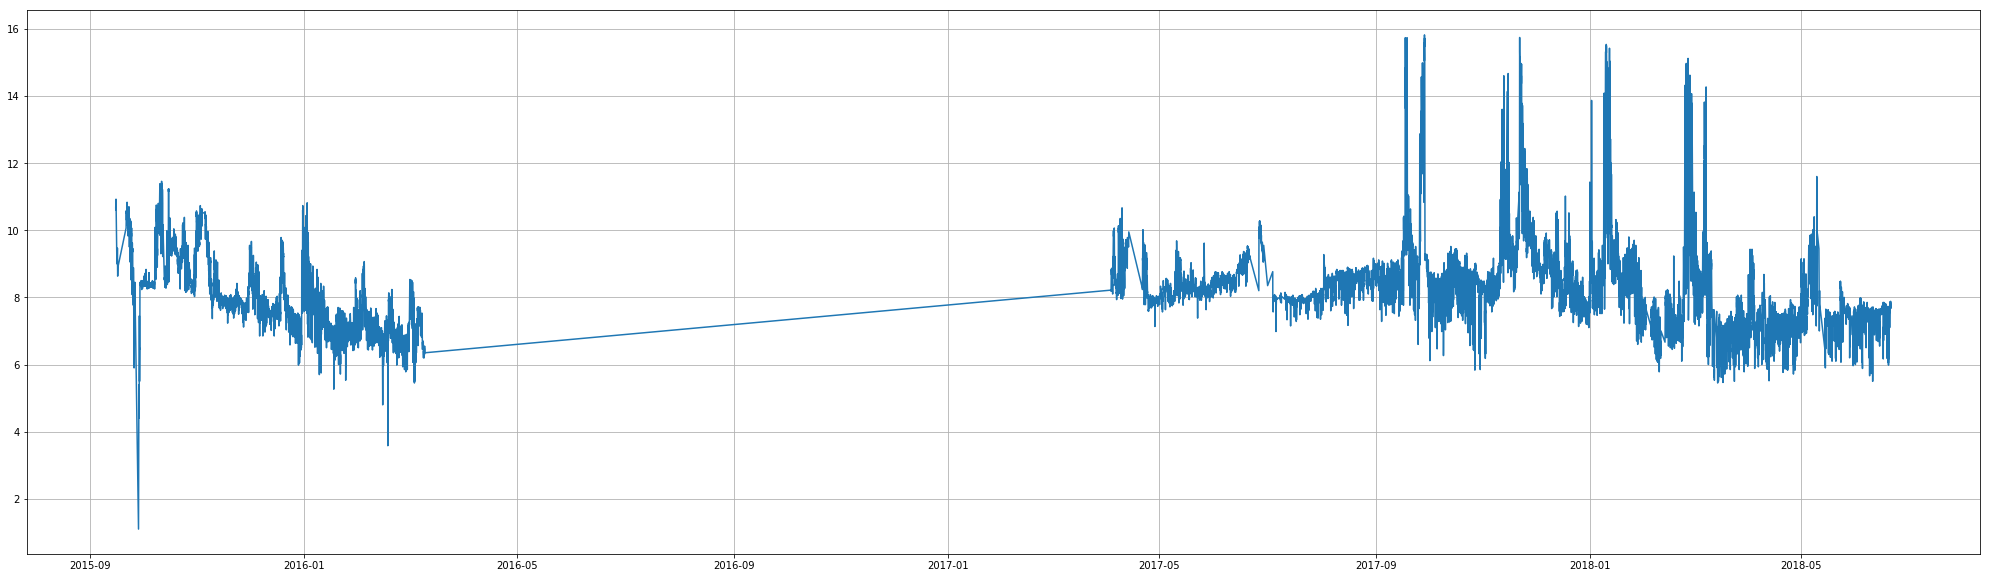

In [72]:
plt.figure(figsize=(35,10))
plt.grid(True)
plt.plot(df['date'].tolist(), df['mean'].tolist())

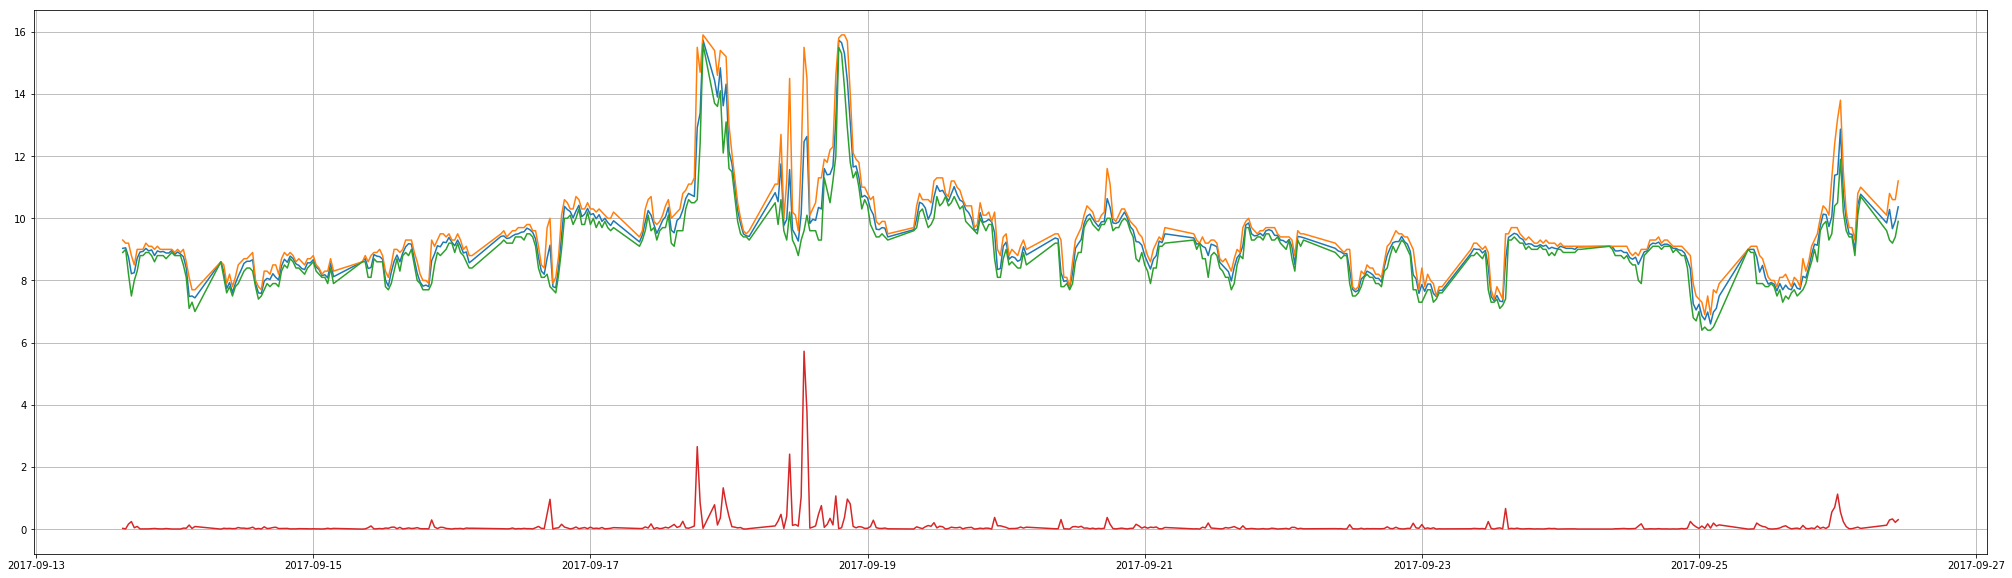

In [71]:
plt.figure(figsize=(35,10))
plt.grid(True)
plt.plot(df['date'].tolist()[14500:15000], df['mean'].tolist()[14500:15000], label='mean')
plt.plot(df['date'].tolist()[14500:15000], df['max'].tolist()[14500:15000], label='max')
plt.plot(df['date'].tolist()[14500:15000], df['min'].tolist()[14500:15000], label='min')
plt.plot(df['date'].tolist()[14500:15000], df['var'].tolist()[14500:15000], label='var')

## using df_30m, define time windown, and find time gaps (missing data) 

In [2]:
df = pd.read_pickle(basePath/'o2mgl_Morrolobos_smooth_30m.pickle')
timeDiff = df.diff(axis = 0, periods = 1)
timeDiff['seconds'] = timeDiff['date'].apply(lambda x: x.seconds)
df.shape, timeDiff.shape

((25960, 5), (25960, 6))

In [3]:
df.head()

,date,mean,max,min,var
0,2015-09-15 18:00:00,10.675000,10.8,10.5,0.015833
1,2015-09-15 18:30:00,10.600000,10.7,10.4,0.016000
2,2015-09-15 19:00:00,10.716667,10.9,10.6,0.013667
3,2015-09-15 19:30:00,10.766667,10.8,10.7,0.002667
4,2015-09-15 20:00:00,10.783333,10.9,10.7,0.005667


In [4]:
freq = collections.Counter(list(timeDiff['seconds']))
freq.most_common(5), 25831 / 26220

([(1800.0, 25626), (3600.0, 113), (5400.0, 62), (7200.0, 27), (18000.0, 25)],
 0.985163996948894)

## only use good consecutive data: MUST be >= min_windown time span

In [5]:
# use the data point from the past 3 days: 3days * 24hours/day * 60 mins/hour / 30 mins
# and the next 6 data point, the last of which is the label
min_windown = int(3 * 24 * 60 / 30 ) + 6
min_windown

150

In [6]:
gap_index = list(timeDiff[timeDiff['seconds'] > 1800].index)
gap_index = [0] + gap_index
len(gap_index), gap_index[:5]

(333, [0, 9, 38, 281, 947])

In [7]:
good_gap_index = [gap_index[i] for i in range(len(gap_index)-1) if gap_index[i+1] - gap_index[i] >= 150]# and gap_index[i+1] - gap_index[i] <= 150]
len(good_gap_index), good_gap_index[:5]

(28, [38, 281, 951, 1201, 1659])

In [8]:
good_date_list = []
good_value_list = []
for i in range(len(good_gap_index)-1):
    good_value_list.append(df.loc[good_gap_index[i]:good_gap_index[i+1]-1, ['mean','max','min','var']])
    good_date_list.append(df.loc[good_gap_index[i]:good_gap_index[i+1]-1, 'date'])
len(good_date_list)

27

In [9]:
a, b = good_value_list[0], good_date_list[0]
type(a), type(b), a.shape, b.shape

(pandas.core.frame.DataFrame, pandas.core.series.Series, (243, 4), (243,))

In [10]:
print(min_windown, type(min_windown))
w = min_windown
data, data_date = [], []
# label, label_date = [], []
for gvl, gdl in zip(good_value_list, good_date_list):
    assert len(gvl) == len(gdl)
    gvl.reset_index(inplace=True)
    gdl = gdl.to_list()
    for i in range(len(gvl) - w):
        data.append(gvl.loc[i:i+w-1, ['mean','max','min','var']].values)
        data_date.append(gdl[i:i+w])      
#         label.append(gvl.loc[i+w, 'mean'])
#         label_date.append(gdl[i+w])

150 <class 'int'>


In [11]:
len(data), len(data[0]), len(data[0][0]), len(data_date), len(data_date[0])

(21005, 150, 4, 21005, 150)

In [12]:
np_data = np.array(data[0][0])
np_data

array([1.00500002e+01, 1.01000004e+01, 9.89999962e+00, 7.00005326e-03])

In [13]:
type(gvl.values)

numpy.ndarray

## train/test split

In [14]:
train_test_cutoff = int(0.8*len(data))
print(len(data), train_test_cutoff, len(data) - train_test_cutoff)

train, test = data[:train_test_cutoff], data[train_test_cutoff:]
train_date, test_date = data_date[:train_test_cutoff], data_date[train_test_cutoff:]

21005 16804 4201


In [15]:
train_data, train_label = [d[:144][:] for d in train], [d[144:][:,0] for d in train]
test_data, test_label = [d[:144][:] for d in test], [d[144:][:,0] for d in test]

len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_label), len(train_label[0])

(16804, 144, 4, 16804, 6)

In [16]:
train_data_date, train_label_date = [d[:144] for d in train_date], [d[144:] for d in train_date]
test_data_date, test_label_date = [d[:144] for d in test_date], [d[144:] for d in test_date]

len(train_data_date), len(train_data_date[0]), len(train_label_date), len(train_label_date[0])

(16804, 144, 16804, 6)

In [17]:
# train_test_cutoff = int(0.8*len(data))
# print(train_test_cutoff)

# train_data, train_label = data[:train_test_cutoff], label[:train_test_cutoff]
# train_data_date, train_label_date = data_date[:train_test_cutoff], label_date[:train_test_cutoff]

# test_data, test_label = data[train_test_cutoff:], label[train_test_cutoff:]
# test_data_date, test_label_date = data_date[train_test_cutoff:], label_date[train_test_cutoff:]
print('train -- vs -- test cutoffdate: ', data_date[train_test_cutoff][0])
print('last train data point: ', train_date[-1][0], 'first test data point: ', test_date[0][0])

train -- vs -- test cutoffdate:  2018-01-15 23:00:00
last train data point:  2018-01-15 22:30:00 first test data point:  2018-01-15 23:00:00


In [18]:
len(train_data), len(test_data), len(data), 16804 + 4201 == 21005, len(train_data[0]), len(test_data[0])

(16804, 4201, 21005, True, 144, 144)

In [21]:
len(train_label), len(test_label), 16804 + 4201 == 21005

(16804, 4201, True)

In [22]:
trn_clas = np.array(train_data)
trn_labels = np.array(train_label)

val_clas = np.array(test_data)
val_labels = np.array(test_label)

In [23]:
trn_clas.shape, trn_labels.shape, val_clas.shape, val_labels.shape

((16804, 144, 4), (16804, 6), (4201, 144, 4), (4201, 6))

In [24]:
df_test = df[df['date'] >= test_date[0][0]].copy(deep=True).reset_index()
print(df_test.shape)
df_test.head()

(5968, 6)


,index,date,mean,max,min,var
0,19992,2018-01-15 23:00:00,9.933333,10.2,9.8,0.022667
1,19993,2018-01-15 23:30:00,10.150000,10.3,10.0,0.011000
2,19994,2018-01-16 00:00:00,10.050000,10.3,9.8,0.027000
3,19995,2018-01-16 00:30:00,10.016667,10.5,9.5,0.149667
4,19996,2018-01-16 01:00:00,10.233333,10.3,10.1,0.006667


In [25]:
df_test.to_pickle(basePath/'df_test_6steps_3hour.pickle')

### model: training and testing

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print('Current PyTorch version: ', torch.__version__)

XTrain, XTest = (torch.from_numpy(data).float() for data in (trn_clas, val_clas))
# # for cross_entropy
# YTrain, YTest = (torch.from_numpy(data).long() for data in (trn_labels, val_labels))
# for BCEWithLogitsLoss
YTrain, YTest = (torch.from_numpy(data).float() for data in (trn_labels, val_labels))

# splitted = (trn_clas_padEncoded, val_clas_padEncoded, trn_labels, val_labels) 
# XTrain, XTest, YTrain, YTest = (torch.from_numpy(data).long() for data in splitted)
trainLoader = DataLoader(TensorDataset(XTrain, YTrain), batch_size=128, num_workers=2, shuffle=False)
testLoader = DataLoader(TensorDataset(XTest, YTest), batch_size=128)

Current PyTorch version:  1.1.0


### Define LSTM Net Class
- train and test

In [27]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
#     epoch_acc = 0
    model.train()
    for x, y in iterator: #tqdm.tqdm(iterator):
#         print('train: ', x.size(), y.size())
        x, y = x.to(device), y.to(device)#.unsqueeze(1)
#         print('train, unsequeeze y: ', x.size(), y.size())
        optimizer.zero_grad()
        preds = model(x)
#         print('train, model output preds: ', preds.size(), y.size())
        loss = criterion(preds, y)
#         acc = binary_accuracy(preds, y)
        loss.backward()
        optimizer.step()
#         optimizer = adjust_learning_rate(optimizer, init_lr, epoch) # adjust learning rate here 

        epoch_loss += loss.item() # need * x[0] when in multi-label mode 
#         epoch_acc += acc.item()
        
    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for x, y in iterator:#tqdm.tqdm(iterator):
            x, y = x.to(device), y.to(device)#.unsqueeze(1)
            preds = model(x)
            loss = criterion(preds, y)
#             acc = binary_accuracy(preds, y)
            
            epoch_loss += loss.item() # need * x[0] when in multi-label mode 
#             epoch_acc += acc.item()
            
    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

In [28]:
LSTMNet_config = {
    "nDims": 4, 
    "nLayers": 2, 
    "drops": [0.1, 0.15, 0.2],
    "lstmNodes": 100,
    "modelFileId": r'LSTM_20190612_smooth_6steps_30min.pth'
}

class LSTMNet(nn.Module):
    def __init__(self, lstDrops, lstmNodes, nDims, nLayers):
        super(LSTMNet, self).__init__()
#         self.emb1 = nn.Embedding(vocabSize, nDims)
        self.drop1 = nn.Dropout(p=lstDrops[0])
        self.lstm = nn.LSTM(nDims, lstmNodes, num_layers=nLayers, dropout=lstDrops[1], batch_first=True)#), bidirectional=True) # batch_first=True 
        self.num_layers = nLayers
        self.hidden_size = lstmNodes
        self.drop2 = nn.Dropout(p=lstDrops[2])
        self.linOut = nn.Linear(lstmNodes, 6)
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         print(x.size()) #torch.Size([96, 864])
#         x = self.emb1(x)
#         x = x.unsqueeze(2)
#         print(x.size()) #torch.Size([96, 864])
        out1, _ = self.lstm(x)#, (h0, c0))
        x = self.drop2(out1[:, -1, :]) # if batch_first = False (default), it should be out1[-1, :, :]
        x = self.linOut(x)
#         print('model output:' ,x.size())
        return x

def predict(input_data, model, device):
    model.to(device)
    model.eval()
    with torch.no_grad():
        input_tensor = torch.from_numpy(input_data).float().to(device)
        prediction = model(input_tensor.unsqueeze(0))
    return prediction.item()

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = None

# LSTMNet 
model = LSTMNet(lstDrops=LSTMNet_config["drops"], lstmNodes=LSTMNet_config["lstmNodes"], nDims=LSTMNet_config["nDims"], 
                        nLayers=LSTMNet_config["nLayers"])
modelFileId = LSTMNet_config["modelFileId"]

# model.load_state_dict(torch.load(basePath/'LSTM_20190607.pth'))

model.to(device)

Using device: cuda:0


LSTMNet(
  (drop1): Dropout(p=0.1)
  (lstm): LSTM(4, 100, num_layers=2, batch_first=True, dropout=0.25)
  (drop2): Dropout(p=0.35)
  (linOut): Linear(in_features=100, out_features=6, bias=True)
)

In [30]:
%%time
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # it was 0.001 
loss_func = nn.MSELoss()#BCEWithLogitsLoss()
loss_func.to(device)
epochs = 120
best_valid_loss = 0.2
print("Total epochs: ", epochs)

for epoch in range(1, epochs + 1):
    train_loss = train(model, trainLoader, opt, loss_func, device)
    valid_loss = evaluate(model, testLoader, loss_func, device)
    
    if epoch % 30 == 0:
        opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) 
    if valid_loss < best_valid_loss: 
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), basePath/modelFileId)
#     train_acc = 0 
#     valid_acc = 0 
#     print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    if epoch % 10 == 0:
        print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Current Best Val.Loss: {best_valid_loss:.3f}')

Total epochs:  120
| Epoch: 10 | Train Loss: 1.724 | Val. Loss: 2.675 | Current Best Val.Loss: 0.200
| Epoch: 20 | Train Loss: 1.853 | Val. Loss: 2.661 | Current Best Val.Loss: 0.200
| Epoch: 30 | Train Loss: 2.198 | Val. Loss: 2.362 | Current Best Val.Loss: 0.200
| Epoch: 40 | Train Loss: 2.147 | Val. Loss: 2.600 | Current Best Val.Loss: 0.200
| Epoch: 50 | Train Loss: 2.280 | Val. Loss: 2.362 | Current Best Val.Loss: 0.200
| Epoch: 60 | Train Loss: 2.255 | Val. Loss: 2.313 | Current Best Val.Loss: 0.200
| Epoch: 70 | Train Loss: 2.212 | Val. Loss: 2.350 | Current Best Val.Loss: 0.200
| Epoch: 80 | Train Loss: 2.123 | Val. Loss: 2.216 | Current Best Val.Loss: 0.200
| Epoch: 90 | Train Loss: 2.149 | Val. Loss: 2.491 | Current Best Val.Loss: 0.200
| Epoch: 100 | Train Loss: 2.260 | Val. Loss: 2.130 | Current Best Val.Loss: 0.200
| Epoch: 110 | Train Loss: 2.237 | Val. Loss: 2.324 | Current Best Val.Loss: 0.200
| Epoch: 120 | Train Loss: 0.910 | Val. Loss: 2.691 | Current Best Val.Loss: 

# Predict

In [38]:
test
yy = [] 
yy_hat = []
model.eval()
with torch.no_grad():
    for x, y in testLoader:#tqdm.tqdm(iterator):
        x, y = x.to(device), y.to(device)#.unsqueeze(1)
        test = y
        preds = model(x)
#         print(y.size(), y[:][-1].shape)
        cpu_y = torch.Tensor.cpu(y).numpy()
#         print(cpu_y.shape, cpu_y[-1, :])
        yy += list(y.cpu().numpy()[:, -1])
        yy_hat += list(preds.cpu().numpy()[:, -1])


In [39]:
# test.cpu().numpy()

# list(test.cpu().numpy()[:, -1])

In [40]:
len(yy), len(yy_hat)

(4201, 4201)

In [41]:
time = [t[-1] for t in test_label_date]

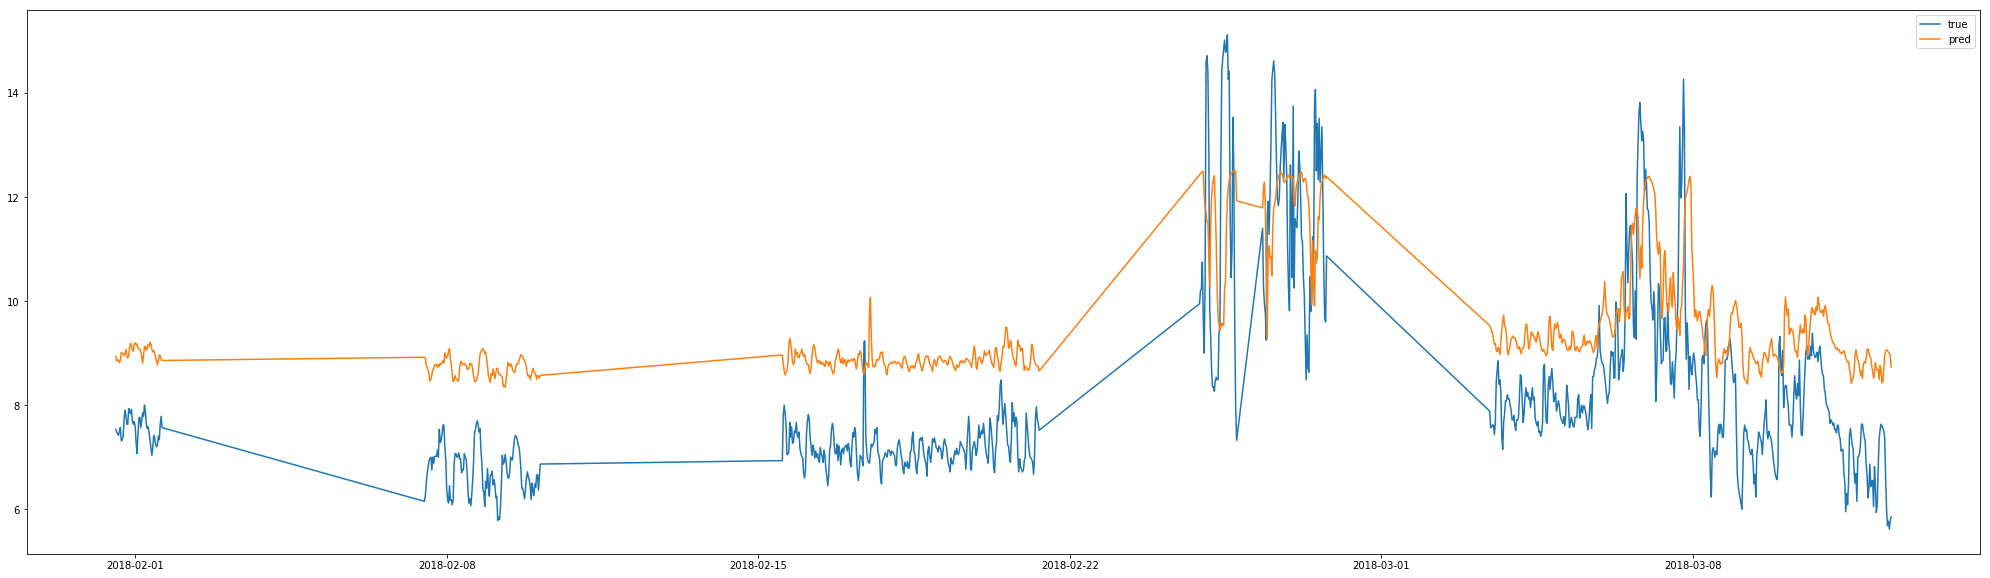

In [55]:
plt.figure(figsize=(35,10))
s = 600
t = 1600
plt.plot(time[s:t], yy[s:t], label='true')
plt.plot(time[s:t], yy_hat[s:t], label='pred')
plt.legend(loc='best')

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
mean_squared_error(yy, yy_hat), sqrt(mean_squared_error(yy, yy_hat))

(2.837346, 1.6844423638003563)

In [44]:
mean_absolute_error(yy, yy_hat), sqrt(mean_absolute_error(yy, yy_hat))

(1.5594643, 1.2487851438264268)

In [49]:
import numpy as np 
# y, y_har: np.array
def MAE(y, y_hat):
    return np.mean(np.abs(y-y_hat))
def RMSE(y, y_hat):
    diff = y-y_hat
    return np.sqrt(np.mean(diff**2))
def MAPE(y, y_hat):
    pt = 100*(y-y_hat)/y
    return np.mean(np.abs(pt))
def MDA(y, y_hat):
    c = np.sign(y[1:] - y[:-1]) == np.sign(y_hat[1:] - y_hat[:-1])
    return 100*np.mean(c)
def accuracy(y, y_hat):
    return 100 - MAPE(y, y_hat)
def sMAPE(y, y_hat):
    return np.mean(200*np.abs(y-y_hat)/(y+y_hat))
def cor(y, y_hat):
    return np.corrcoef(y, y_hat)[0][1]
# def scaled_error()

In [50]:
yy = np.array(yy)
yy_hat = np.array(yy_hat)
print('MAE: ', MAE(yy, yy_hat))
print('RMSE: ', RMSE(yy, yy_hat))
print('MAPE: ', MAPE(yy, yy_hat))
print('MDA: ', MDA(yy, yy_hat))
print('accuracy: ', accuracy(yy, yy_hat))
print('sMAPE: ', sMAPE(yy, yy_hat))
print('cor: ', cor(yy, yy_hat))

MAE:  1.5594643
RMSE:  1.6844424
MAPE:  21.319902
MDA:  45.42857142857143
accuracy:  78.68009757995605
sMAPE:  18.94947
cor:  0.7329479622315856


In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = None

# LSTMNet 
model = LSTMNet(lstDrops=LSTMNet_config["drops"], lstmNodes=LSTMNet_config["lstmNodes"], nDims=LSTMNet_config["nDims"], 
                        nLayers=LSTMNet_config["nLayers"])
modelFileId = LSTMNet_config["modelFileId"]

model.load_state_dict(torch.load(basePath/'LSTM_20190609_smooth_30min.pth'))

model.to(device)

Using device: cuda:0


LSTMNet(
  (drop1): Dropout(p=0.1)
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True, dropout=0.35)
  (drop2): Dropout(p=0.45)
  (linOut): Linear(in_features=100, out_features=1, bias=True)
)

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
combine = []
for d, x, y in zip(test_label_date, test_data, test_label):
    pred = predict(np.array(x), model, device)
    combine.append((d, y, pred))

In [32]:
len(test_data), len(test_label_date), len(combine)

(4388, 4388, 4388)

In [33]:
res = pd.DataFrame(combine, columns = ['date', 'true', 'pred'])
print(res.shape)
res.head()

(4388, 3)


,date,true,pred
0,2018-01-11 06:30:00,12.900000,13.126344
1,2018-01-11 07:00:00,13.016667,12.808985
2,2018-01-11 07:30:00,14.250000,12.993759
3,2018-01-11 08:00:00,11.866667,13.989810
4,2018-01-11 08:30:00,12.216667,11.598040


In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
res = res
mean_squared_error(res['true'], res['pred']), sqrt(mean_squared_error(res['true'], res['pred']))

(0.17957003505536684, 0.4237570472043702)

In [35]:
mean_absolute_error(res['true'], res['pred']), sqrt(mean_absolute_error(res['true'], res['pred']))

(0.25730387168061625, 0.5072512904671769)

/home/app_trr_dev_18-1/anaconda3/envs/dlp37/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0.5, 1.0, 'true:blue vs pred:red')

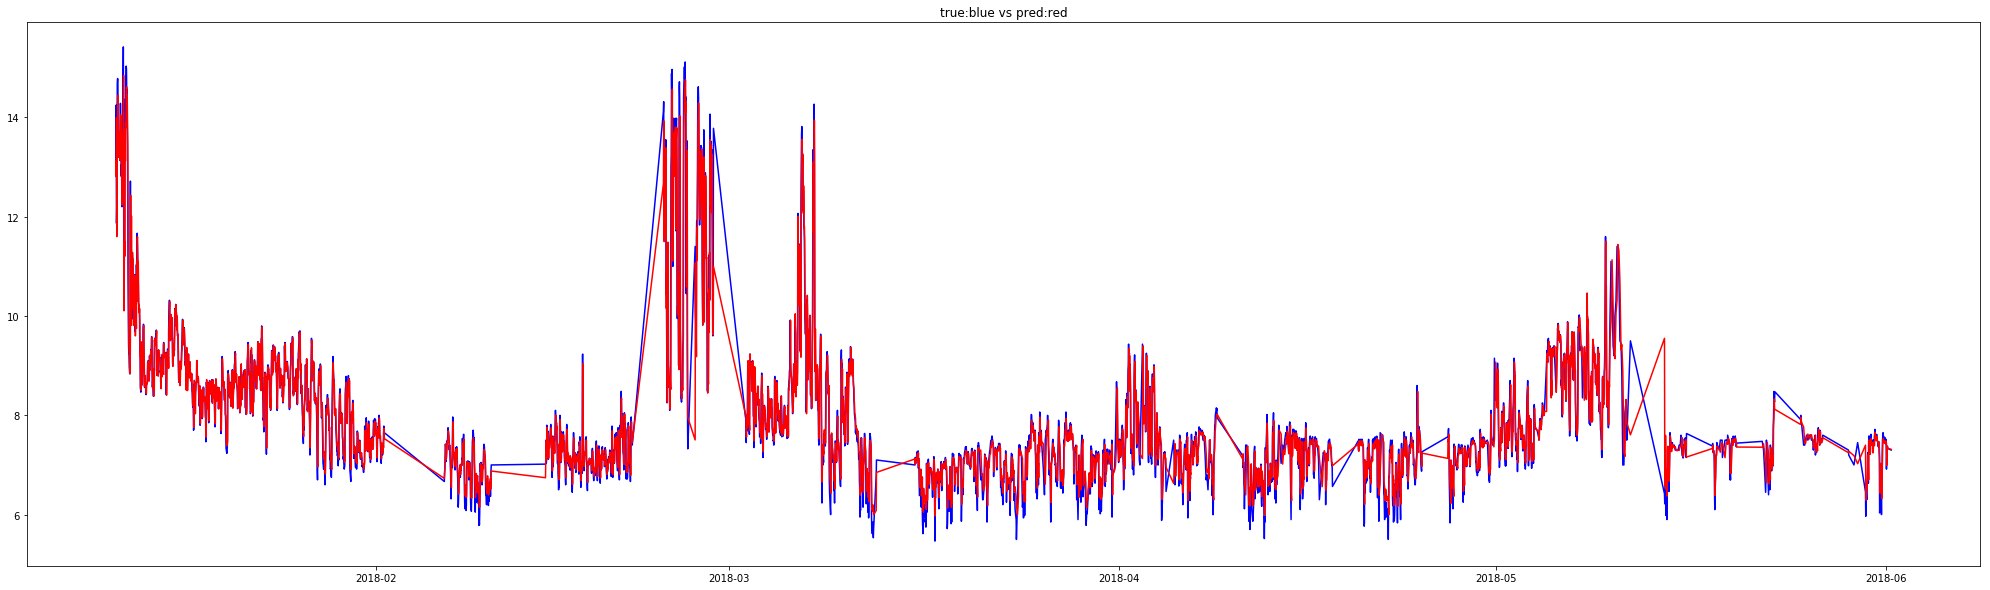

In [36]:
true_label = list(res['true'])
pred_label = list(res['pred'])

plt.figure(figsize=(35,10))
start = 0#4500//6
end = 4500 #len(res)#10500//6
plt.plot(test_label_date[start:end], true_label[start:end], color='b')
plt.plot(test_label_date[start:end], pred_label[start:end], color='r')
plt.title('true:blue vs pred:red')

# prediction on 1 hour, 3 hour and 6 hour

### construct test data for 1 hour, 3 hour and 6 hour first

In [3]:
df_test = pd.read_pickle(basePath/'df_test.pickle')
print(df_test.shape)
df_test.head()

(6421, 3)


,index,date,value
0,19799,2018-01-11 07:00:00,13.016667
1,19800,2018-01-11 07:30:00,14.250000
2,19801,2018-01-11 08:00:00,11.866667
3,19802,2018-01-11 08:30:00,12.216667
4,19803,2018-01-11 09:00:00,13.283333


In [4]:
timeDiff = df_test.diff(axis = 0, periods = 1)
timeDiff['seconds'] = timeDiff['date'].apply(lambda x: x.seconds)
timeDiff[timeDiff['seconds'] == 0].head()

,index,date,value,seconds


In [5]:
freq = collections.Counter(list(timeDiff['seconds']))
freq.most_common(5), 3985 / 4283

([(1800.0, 6110), (3600.0, 141), (7200.0, 66), (5400.0, 54), (9000.0, 12)],
 0.930422600980621)

In [6]:
timeDiff[timeDiff['seconds'] > 1800].head()

,index,date,value,seconds
1025,1.0,2 days 18:30:00,-0.500000,66600.0
1301,1.0,2 days 07:30:00,-0.333333,27000.0
1729,1.0,0 days 11:30:00,0.050000,41400.0
1919,1.0,0 days 14:00:00,4.075000,50400.0
1990,1.0,0 days 13:00:00,-5.080000,46800.0


In [7]:
df_test.loc[1024], df_test.loc[1025]

(index                  20823
 date     2018-02-01 15:00:00
 value                   7.65
 Name: 1024, dtype: object, index                  20824
 date     2018-02-04 09:30:00
 value                   7.15
 Name: 1025, dtype: object)

### 1 hour

In [10]:
min_windown_1hour = int(min_windown + 60 / 30 - 1)
min_windown, min_windown_1hour

(96, 97)

In [11]:
gap_index = list(timeDiff[timeDiff['seconds'] > 1800].index)
gap_index = [0] + gap_index
len(gap_index), gap_index[:5]

(311, [0, 1025, 1301, 1729, 1919])

In [44]:
good_gap_index = [gap_index[i] for i in range(len(gap_index)-1) if gap_index[i+1] - gap_index[i] > min_windown_1hour]
good_gap_index

[0, 1025, 1301, 1729, 1990, 2578, 3618, 3966, 4268, 4947, 5216, 5352, 5539]

In [45]:
good_date_list = []
good_value_list = []
for i in range(len(good_gap_index)-1):
    good_date_list.append(list(df_test.loc[good_gap_index[i]:good_gap_index[i+1]-1, 'date']))
    good_value_list.append(list(df_test.loc[good_gap_index[i]:good_gap_index[i+1]-1, 'value']))

In [46]:
print(min_windown_1hour, type(min_windown_1hour))
w = min_windown_1hour
data, data_date = [], []
label, label_date = [], []
for gvl, gdl in zip(good_value_list, good_date_list):
    assert len(gvl) == len(gdl)
    for i in range(len(gvl) - w):
        data.append(gvl[i:i+w])
        data_date.append(gdl[i:i+w])
        
        label.append(gvl[i+w])
        label_date.append(gdl[i+w])
len(data), len(data_date[0])

97 <class 'int'>


(4375, 97)

In [47]:
test_data_1hour = []
test_data_date_1hour = []
test_label_1hour = []
test_label_date_1hour = []
for d, dd, l, ld in zip(data, data_date, label, label_date):
    test_data_1hour.append(d[:min_windown])
    test_data_date_1hour.append(dd[:min_windown])
    test_label_1hour.append(l)
    test_label_date_1hour.append(ld)

In [48]:
len(test_data_1hour), len(test_data_1hour[0]), test_label_1hour[0], test_label_date_1hour[0], test_data_date_1hour[0][-1]

(4375,
 96,
 9.283333333333333,
 Timestamp('2018-01-13 07:30:00'),
 Timestamp('2018-01-13 06:30:00'))

In [49]:
combine_1hour = []
n = 1
for td, tl, tld in zip(test_data_1hour, test_label_1hour, test_label_date_1hour):
    temp_td = td 
    pred = predict(np.array(temp_td[0:]), model, device)
    temp_td.append(pred)
    
    pred_1hour = predict(np.array(temp_td[1:]), model, device)
    combine_1hour.append((tld, tl, pred_1hour))

In [50]:
res_1hour = pd.DataFrame(combine_1hour, columns = ['date', 'true', 'pred'])
print(res_1hour.shape)
res_1hour.head()

(4375, 3)


,date,true,pred
0,2018-01-13 07:30:00,9.283333,8.542747
1,2018-01-13 08:00:00,8.816667,9.479954
2,2018-01-13 08:30:00,8.633333,9.235046
3,2018-01-13 09:00:00,8.666667,8.733627
4,2018-01-13 09:30:00,8.966667,8.620457


In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
res = res_1hour
mean_squared_error(res['true'], res['pred']), sqrt(mean_squared_error(res['true'], res['pred']))

(0.31866932437923967, 0.5645080374797508)

In [52]:
mean_absolute_error(res['true'], res_1hour['pred']), sqrt(mean_absolute_error(res['true'], res_1hour['pred']))

(0.3548792914447395, 0.5957174594090218)

In [ ]:
true_label = list(res_1hour['true'])
pred_label = list(res_1hour['pred'])

plt.figure(figsize=(35,10))
start = 0 #500
end = len(res) #1000
plt.plot(test_label_date_1hour[start:end], true_label[start:end], color='b')
plt.plot(test_label_date_1hour[start:end], pred_label[start:end], color='r')
plt.title('true:blue vs pred:red')

Text(0.5, 1.0, 'true:blue vs pred:red')

## 3 hours

In [12]:
min_windown_3hour = int(min_windown + 3 * 60 / 30 - 1)
min_windown, min_windown_3hour

(96, 101)

In [13]:
gap_index = list(timeDiff[timeDiff['seconds'] > 1800].index)
gap_index = [0] + gap_index
len(gap_index), gap_index[:5]

(311, [0, 1025, 1301, 1729, 1919])

In [14]:
good_gap_index = [gap_index[i] for i in range(len(gap_index)-1) if gap_index[i+1] - gap_index[i] > min_windown_3hour]
good_gap_index

[0, 1025, 1301, 1729, 1990, 2578, 3618, 3966, 4268, 4947, 5216, 5539]

In [15]:
good_date_list = []
good_value_list = []
for i in range(len(good_gap_index)-1):
    good_date_list.append(list(df_test.loc[good_gap_index[i]:good_gap_index[i+1]-1, 'date']))
    good_value_list.append(list(df_test.loc[good_gap_index[i]:good_gap_index[i+1]-1, 'value']))

In [16]:
print(min_windown_3hour, type(min_windown_3hour))
w = min_windown_3hour
data, data_date = [], []
label, label_date = [], []
for gvl, gdl in zip(good_value_list, good_date_list):
    assert len(gvl) == len(gdl)
    for i in range(len(gvl) - w):
        data.append(gvl[i:i+w])
        data_date.append(gdl[i:i+w])
        
        label.append(gvl[i+w])
        label_date.append(gdl[i+w])

101 <class 'int'>


In [17]:
test_data_3hour = []
test_data_date_3hour = []
test_label_3hour = []
test_label_date_3hour = []
for d, dd, l, ld in zip(data, data_date, label, label_date):
    test_data_3hour.append(d[:min_windown])
    test_data_date_3hour.append(dd[:min_windown])
    test_label_3hour.append(l)
    test_label_date_3hour.append(ld)

In [18]:
len(test_data_3hour[0]), test_label_3hour[0], test_label_date_3hour[0], test_data_date_3hour[0][-1]

(96,
 8.966666666666667,
 Timestamp('2018-01-13 09:30:00'),
 Timestamp('2018-01-13 06:30:00'))

In [23]:
combine_3hour = []
n = 1
for td, tl, tld in zip(test_data_3hour, test_label_3hour, test_label_date_3hour):
    for i in range(6):
        pred = predict(np.array(td[i:]), model, device)
        td.append(pred)
    pred_3hour = predict(np.array(td[6:]), model, device)
    combine_3hour.append((tld, tl, pred_3hour))

In [24]:
res_3hour = pd.DataFrame(combine_3hour, columns = ['date', 'true', 'pred'])
print(res_3hour.shape)
res_3hour.head()

(4428, 3)


,date,true,pred
0,2018-01-13 09:30:00,8.966667,8.649055
1,2018-01-13 10:00:00,9.200000,9.327345
2,2018-01-13 10:30:00,9.400000,9.135466
3,2018-01-13 11:00:00,9.750000,8.775876
4,2018-01-13 11:30:00,9.833333,8.698480


In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
res = res_3hour
mean_squared_error(res['true'], res['pred']), sqrt(mean_squared_error(res['true'], res['pred']))

(0.6403461435103819, 0.8002163104501069)

In [26]:
mean_absolute_error(res['true'], res['pred']), sqrt(mean_absolute_error(res['true'], res['pred']))

(0.512149583174551, 0.7156462695875323)

Text(0.5, 1.0, 'true:blue vs pred:red')

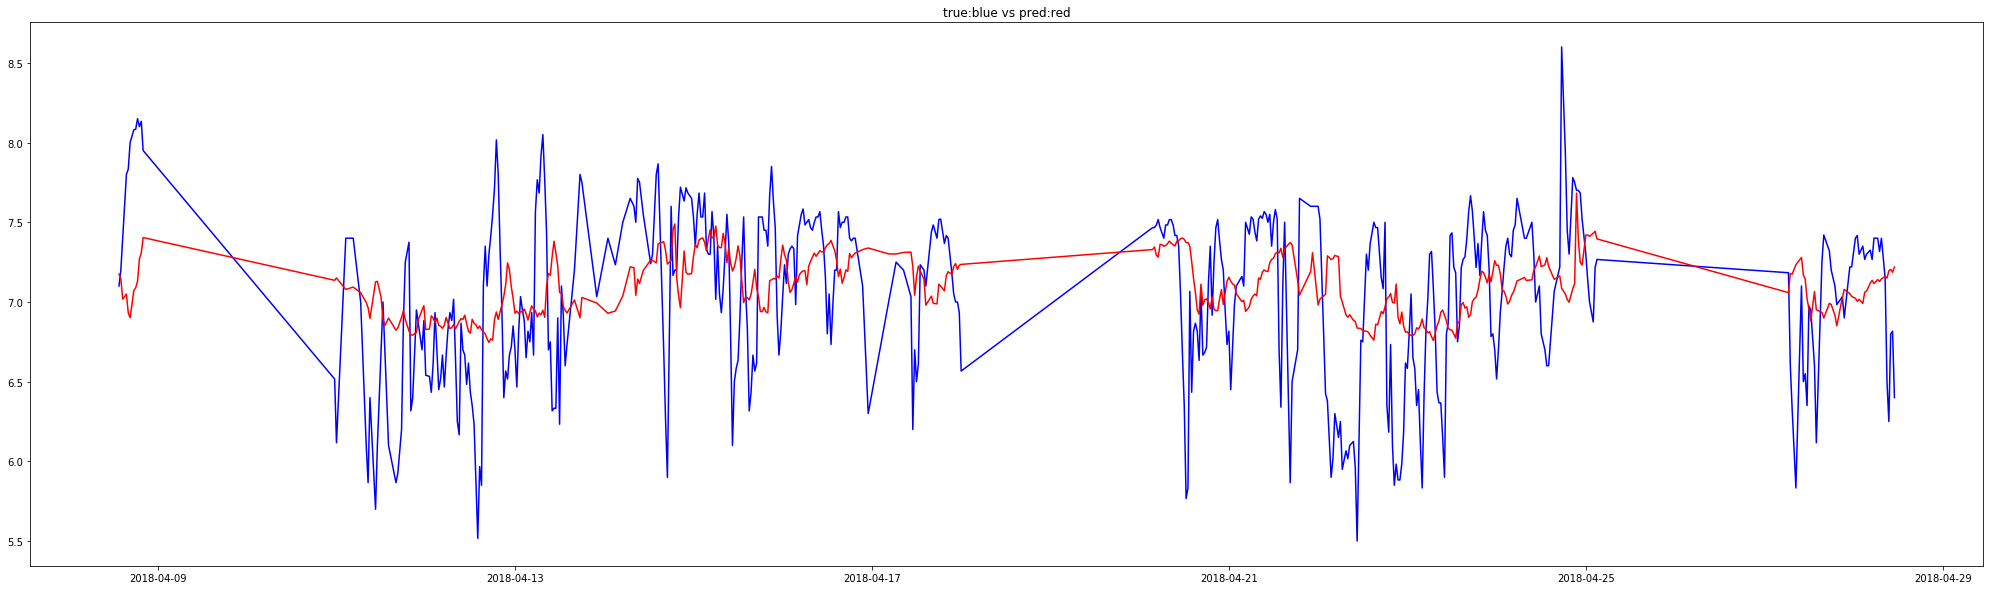

In [38]:
true_label = list(res_3hour['true'])
pred_label = list(res_3hour['pred']) 

plt.figure(figsize=(35,10))
start = 3000# 50
end = 3500#len(res_3hour)#150
plt.plot(test_label_date_3hour[start:end], true_label[start:end], color='b')
plt.plot(test_label_date_3hour[start:end], pred_label[start:end], color='r')
plt.title('true:blue vs pred:red')

In [29]:
res_3hour.head()

,date,true,pred
0,2018-01-13 09:30:00,8.966667,8.649055
1,2018-01-13 10:00:00,9.200000,9.327345
2,2018-01-13 10:30:00,9.400000,9.135466
3,2018-01-13 11:00:00,9.750000,8.775876
4,2018-01-13 11:30:00,9.833333,8.698480


In [30]:
res_3hour.to_csv(basePath/'res_3_hour.csv', index=False)

In [34]:
res_3hour['diff'] = abs(res_3hour['true'] - res_3hour['pred'])

In [36]:
res_3hour.sort_values('diff', ascending=False)

,date,true,pred,diff
1454,2018-02-24 12:00:00,14.966667,8.618710,6.347957
1500,2018-02-25 11:00:00,14.833333,8.635934,6.197399
1452,2018-02-24 11:00:00,14.883333,8.784503,6.098830
1499,2018-02-25 10:30:00,14.666667,8.627298,6.039368
1498,2018-02-25 10:00:00,14.416667,8.673400,5.743267
1501,2018-02-25 11:30:00,15.016667,9.284073,5.732594
1453,2018-02-24 11:30:00,14.383333,8.660442,5.722891
1502,2018-02-25 12:00:00,14.783333,9.327194,5.456139
1489,2018-02-25 05:30:00,8.350000,13.508532,5.158532
1525,2018-02-26 13:00:00,14.250000,9.128686,5.121314


## 6 hour

In [169]:
min_windown_6hour = int(min_windown + 6 * 60 / 30 - 1)
min_windown, min_windown_3hour

(144, 149)

In [ ]:
# everything else is the same

## End of generating final model file
# ***

In [29]:
df[df.isnull().any(axis=1)], df.loc[1,'date'] > df.loc[0,'date'] 

(Empty DataFrame
 Columns: [site_name, date, value, depth]
 Index: [], True)

In [104]:
a = df.loc[1,'date'] - df.loc[0,'date']

In [107]:
a.seconds

300000000000

In [133]:
a = df.loc[1,'date']
b = df.loc[0, 'date']

In [135]:
a.microsecond, a.second 

(0, 0)

In [125]:
df.loc[218981, ]

date     2018-06-20 22:35:00
value                    7.7
Name: 218981, dtype: object

In [122]:
df.loc[218981, ]

date     2018-06-20 22:35:00
value                    7.7
Name: 218981, dtype: object

In [16]:
for index, row in df.iterrows():
    if index > 1 and df.loc[index, 'date'] < df.loc[index-1, 'date']:
        print('error', index)

In [109]:
gap_index = [] 
for index, row in df.iterrows():
    if index > 1 and (df.loc[index, 'date'] - df.loc[index-1, 'date']).seconds > 500:
        gap_index.append(index)
len(gap_index)

1126

In [ ]:
gap_index = []
for index, date in df.iterrows():
    if index > 1 and (df.loc[index, 'date'] - df.loc[index-1, 'date']).seconds > 301:
        gap_index.append(index)
len(gap_index)

In [108]:
len(gap_index), gap_index[:5]

(673, [50, 223, 1685, 5683, 5706])

In [87]:
gap_length = [gap_index[i] - gap_index[i-1] for i in range(1,len(gap_index))]

In [83]:
df.loc[49,]

site_name             Morrolobos
date         2015-09-15 21:46:00
value                       10.8
depth                          5
Name: 49, dtype: object

In [84]:
df.loc[50,]

site_name             Morrolobos
date         2015-09-16 09:44:00
value                          9
depth                          5
Name: 50, dtype: object

In [64]:
min(df['date']), max(df['date'])

(Timestamp('2015-09-15 17:42:00'), Timestamp('2018-06-20 23:55:00'))

In [32]:
df['year_monthofyear_date'] = df['date'].apply(lambda x: str(x.year) + '_' + f"{x.month:02d}")

In [ ]:
# plt.hist(df['year_monthofyear_date'])

In [34]:
df.groupby('year_monthofyear_date').size().to_frame('size').sort_values('year_monthofyear_date', ascending=False)

,size
year_monthofyear_date,
2018_06,7663
2018_05,20988
2018_04,30580
2018_03,18083
2018_02,6153
2018_01,8925
2017_12,8381
2017_11,7990
2017_10,8260


In [ ]:
df['year_monthofyear_date'] = df['date'].apply(lambda x: str(x.year) + '_' + f"{x.month:02d}")

In [75]:
window = 3
window * 24 * 12 # days, 3*24*12

864

In [49]:
df['date_toordinal'] = df['date'].apply(lambda x: x.toordinal())

In [54]:
df.head()

,site_name,date,value,depth,year_monthofyear_date,date_toordinal
0,Morrolobos,2015-09-15 17:42:00,10.8,5.0,2015_09,735856
1,Morrolobos,2015-09-15 17:47:00,10.7,5.0,2015_09,735856
2,Morrolobos,2015-09-15 17:52:00,10.5,5.0,2015_09,735856
3,Morrolobos,2015-09-15 17:57:00,10.7,5.0,2015_09,735856
4,Morrolobos,2015-09-15 18:02:00,10.7,5.0,2015_09,735856


In [65]:
list_of_dts = list(df['date'])
days = {}
for dt in list_of_dts:
    days.setdefault(dt.toordinal(), []).append(dt)
len(days)

595

In [68]:
len(days.keys())

595

In [69]:
a = [days.get(day, []) for day in range(min(days), max(days)+1)]

In [55]:
# data = []
# for index, row in df.iterrows():

SyntaxError: unexpected EOF while parsing (<ipython-input-55-fc45cc11f9b7>, line 2)

In [41]:
import datetime
list_of_dts = [
              datetime.datetime(2012,1,1,0,0,0),
              datetime.datetime(2012,1,1,1,0,0),
              datetime.datetime(2012,1,2,0,0,0),
              datetime.datetime(2012,1,3,0,0,0),
              datetime.datetime(2012,1,5,0,0,0),
              ]

days = {}
for dt in list_of_dts:
    days.setdefault(dt.toordinal(), []).append(dt)

In [42]:
days

{734503: [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 1, 1, 1, 0)],
 734504: [datetime.datetime(2012, 1, 2, 0, 0)],
 734505: [datetime.datetime(2012, 1, 3, 0, 0)],
 734507: [datetime.datetime(2012, 1, 5, 0, 0)]}

In [45]:
a = datetime.datetime(2012,1,1,12,3,0) 

In [48]:
a.toordinal()

734503